Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами
Цель: В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.

Часть 1. Парсинг

По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).
Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.

In [47]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек 
import time          # Библиотека для времени

from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from itertools import groupby
import re
# подгрузим один из методов этой библиотеки
from ftfy import fix_text
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
import pymorphy2
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from fake_useragent import UserAgent
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /home/nata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
link = 'https://cdek.market/'

In [3]:
main_page = 'https://cdek.market/c/308/smartfony/'

In [4]:
def get_soup(page_link:str):
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
    if not response.ok:
        return []
    
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')
    return soup

In [5]:
electronik_soup = get_soup(main_page)

In [6]:
def get_ref(div_class, soup):
    _refs = []
    try:
        refs = soup.find("div", attrs={'class':div_class})
        refs = refs.findAll("a")
        for cat in refs:
            if 'href' in cat.attrs: 
                _refs.append(cat.attrs['href'])
        _refs = [el for el, _ in groupby(_refs)]
    except:
        print("Something went wrong")
    finally: 
        return _refs

In [7]:
categories = get_ref('ty-pagination__items', electronik_soup)

In [8]:
categories

['https://cdek.market/c/308/smartfony/page-2/',
 'https://cdek.market/c/308/smartfony/page-3/',
 'https://cdek.market/c/308/smartfony/page-4/',
 'https://cdek.market/c/308/smartfony/page-5/',
 'https://cdek.market/c/308/smartfony/page-6/',
 'https://cdek.market/c/308/smartfony/page-7/',
 'https://cdek.market/c/308/smartfony/page-8/']

Достаем инфу по товарам

In [9]:
category_refs = []
for category in categories:
    product_soup = get_soup(category)
    _category_refs = get_ref('grid-list', product_soup)
    category_refs = category_refs + _category_refs

In [10]:
category_refs[0]

'https://cdek.market/p/10165558/vertex-impress-astra-grafit/'

In [11]:
product_soup = get_soup(category_refs[15])
    

In [12]:
name = product_soup.find("h1").text
name

'Vertex Impress Rosso графит'

In [13]:
text_about = product_soup.find("div", attrs={'class':"ty-wysiwyg-content content-description"}).text.strip()
text_about[:500]

'Диагональ экрана (дюймы):5.5\nТип экрана:IPS\nСеть:GSM,3G,LTE\nФункции:Wi-Fi,Bluetooth,GPS\nОперативная память:1 ГБ\nВстроенная память:8 ГБ\nОС:Android 8.0\nПроцессор:MediaTek\nФронтальная камера (Мп):5\nКоличество SIM: 2\nФормат SIM:Micro-SIM\nАккумулятор (мАч):2700\nЦвет: Графит\nОсобенности:microSD,датчик приближения'

In [14]:
amount = product_soup.find("span", attrs={"class":"ty-qty-in-stock ty-control-group__item"}).text.strip()
num_list = int(re.sub('[^0-9]+', '', amount))
num_list

1

In [15]:
def get_product_info(product_link):
    try:
        product_soup = get_soup(product_link)
        name = product_soup.find("h1").text.strip()
        text_about = product_soup.find("div", attrs={'class':"ty-wysiwyg-content content-description"}).text.strip()
        amount = product_soup.find("span", attrs={"class":"ty-qty-in-stock ty-control-group__item"}).text.strip()
        price = product_soup.find("span", attrs={"class":"ty-price-num"}).text.strip()
        amount = re.sub('[^0-9]+', '', amount)
        price = re.sub('[^0-9.]+', '', price)
    except:
        name = ''
        text_about = ''
        amount = '0'
        price = '0'
    return {'name':name, 'text':text_about, 'amount':amount, 'price':price}

In [16]:
def get_products_info_df(main_page):
    products_info = []
    electronik_soup = get_soup(main_page)
    pages = get_ref('ty-pagination__items', electronik_soup)
    pages.append(main_page)
    for page in pages:
        page_soup = get_soup(page)
        category_refs = get_ref('grid-list', page_soup)
        for category_ref in category_refs:
            _info = {}
            _info = get_product_info(category_ref)
            if _info['name'] and _info not in products_info:
                product_info = {}
                product_info['category'] = category_ref
                product_info.update(_info)
                products_info.append(product_info)
            time.sleep(0.3)
    products_df = pd.DataFrame(products_info)
    return products_df

In [17]:
products_df = get_products_info_df(main_page)

In [18]:
products_df = products_df.drop_duplicates(['name','text','price'], keep='last')

In [19]:
products_df.head(10)

,category,name,text,amount,price
7,https://cdek.market/index.php?dispatch=product...,Huawei P30 Северное сияние (Голубой),"Экран:6.1 Разрешение:2340x1080 (19.5:9), 422 ...",1,35490.00
11,https://cdek.market/index.php?dispatch=product...,Vertex Impress Sunset черный,Диагональ экрана (дюймы):5.5Тип экрана:IPSСеть...,1,5990.00
15,https://cdek.market/index.php?dispatch=product...,Vertex Impress Rosso графит,Диагональ экрана (дюймы):5.5\nТип экрана:IPS\n...,1,5990.00
19,https://cdek.market/index.php?dispatch=product...,ZTE Blade A5 2020 черный,"Диагональ экрана (дюймы):6,088Тип экрана:IPSСе...",1,6990.00
23,https://cdek.market/index.php?dispatch=product...,Vertex Impress Vira NFC черный,Диагональ экрана (дюймы):5.5Тип экрана:IPSСеть...,1,6990.00
27,https://cdek.market/index.php?dispatch=product...,Vertex Impress Luck NFC черный,Диагональ экрана (дюймы):5Тип экрана:IPSСеть:G...,1,4990.00
31,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 32GB BLACK,Xiaomi Redmi 4X обладает самыми важными качест...,10,8890.00
35,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 64GB BLACK,Xiaomi Redmi 4X обладает самыми важными качест...,10,9890.00
39,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 16GB Gold,Xiaomi Redmi 4X обладает самыми важными качест...,10,6990.00
43,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 32GB Gold,Xiaomi Redmi 4X обладает самыми важными качест...,10,8890.00


In [40]:
products_df.to_csv('~/parse.csv')

# Часть 2. NLP

Часть 2. NLP

1. Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования
2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена
3. Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической
4. Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик
5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.

Ручной анализ

In [41]:
data = pd.read_csv('~/parse.csv')

In [42]:
data.head(10)

,Unnamed: 0,category,name,text,amount,price
0,7,https://cdek.market/index.php?dispatch=product...,Huawei P30 Северное сияние (Голубой),"Экран:6.1 Разрешение:2340x1080 (19.5:9), 422 ...",1,35490.0
1,11,https://cdek.market/index.php?dispatch=product...,Vertex Impress Sunset черный,Диагональ экрана (дюймы):5.5Тип экрана:IPSСеть...,1,5990.0
2,15,https://cdek.market/index.php?dispatch=product...,Vertex Impress Rosso графит,Диагональ экрана (дюймы):5.5\nТип экрана:IPS\n...,1,5990.0
3,19,https://cdek.market/index.php?dispatch=product...,ZTE Blade A5 2020 черный,"Диагональ экрана (дюймы):6,088Тип экрана:IPSСе...",1,6990.0
4,23,https://cdek.market/index.php?dispatch=product...,Vertex Impress Vira NFC черный,Диагональ экрана (дюймы):5.5Тип экрана:IPSСеть...,1,6990.0
5,27,https://cdek.market/index.php?dispatch=product...,Vertex Impress Luck NFC черный,Диагональ экрана (дюймы):5Тип экрана:IPSСеть:G...,1,4990.0
6,31,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 32GB BLACK,Xiaomi Redmi 4X обладает самыми важными качест...,10,8890.0
7,35,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 64GB BLACK,Xiaomi Redmi 4X обладает самыми важными качест...,10,9890.0
8,39,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 16GB Gold,Xiaomi Redmi 4X обладает самыми важными качест...,10,6990.0
9,43,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 32GB Gold,Xiaomi Redmi 4X обладает самыми важными качест...,10,8890.0


In [43]:
data.columns

Index(['Unnamed: 0', 'category', 'name', 'text', 'amount', 'price'], dtype='object')

In [44]:
data = data.drop(['Unnamed: 0'], axis=1)

In [45]:
data.head(10)

,category,name,text,amount,price
0,https://cdek.market/index.php?dispatch=product...,Huawei P30 Северное сияние (Голубой),"Экран:6.1 Разрешение:2340x1080 (19.5:9), 422 ...",1,35490.0
1,https://cdek.market/index.php?dispatch=product...,Vertex Impress Sunset черный,Диагональ экрана (дюймы):5.5Тип экрана:IPSСеть...,1,5990.0
2,https://cdek.market/index.php?dispatch=product...,Vertex Impress Rosso графит,Диагональ экрана (дюймы):5.5\nТип экрана:IPS\n...,1,5990.0
3,https://cdek.market/index.php?dispatch=product...,ZTE Blade A5 2020 черный,"Диагональ экрана (дюймы):6,088Тип экрана:IPSСе...",1,6990.0
4,https://cdek.market/index.php?dispatch=product...,Vertex Impress Vira NFC черный,Диагональ экрана (дюймы):5.5Тип экрана:IPSСеть...,1,6990.0
5,https://cdek.market/index.php?dispatch=product...,Vertex Impress Luck NFC черный,Диагональ экрана (дюймы):5Тип экрана:IPSСеть:G...,1,4990.0
6,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 32GB BLACK,Xiaomi Redmi 4X обладает самыми важными качест...,10,8890.0
7,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 64GB BLACK,Xiaomi Redmi 4X обладает самыми важными качест...,10,9890.0
8,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 16GB Gold,Xiaomi Redmi 4X обладает самыми важными качест...,10,6990.0
9,https://cdek.market/index.php?dispatch=product...,СМАРТФОН XIAOMI REDMI 4X 32GB Gold,Xiaomi Redmi 4X обладает самыми важными качест...,10,8890.0


Уберем проблемы с кодировкой ftfy

In [26]:
text = ' '.join(str(e) for e in data['text'])

In [27]:
text = fix_text(text, normalization='NFKC')

Нормализация -
Приведение токенов к единому регистру, чтобы избавиться от поверхностной разницы в написании

In [28]:
text = text.lower()

Разбиение на токены

In [29]:
tokens = nltk.word_tokenize(text)
tokens

['экран:6.1',
 'разрешение:2340x1080',
 '(',
 '19.5:9',
 ')',
 ',',
 '422',
 'ppiпамять:64',
 'гб',
 ',',
 'озу',
 '6',
 'гпроцессор:8',
 'ядер',
 '(',
 'а',
 ')',
 ',',
 '2.6',
 'ггцкамера:3',
 'модулявидео',
 ':',
 'fullhd',
 '60',
 'к/с',
 ',',
 'ultrahd',
 '4k',
 ',',
 'стабилизацияемкость',
 'батареи:3650',
 'мачвес:165',
 'г',
 'диагональ',
 'экрана',
 '(',
 'дюймы',
 ')',
 ':5.5тип',
 'экрана',
 ':',
 'ipsсеть',
 ':',
 'gsm,3g',
 ',',
 'lteфункции',
 ':',
 'wi-fi',
 ',',
 'bluetooth',
 ',',
 'gpsоперативная',
 'память:1',
 'гбвстроенная',
 'память:8',
 'гбос',
 ':',
 'android',
 '8.0процессор',
 ':',
 'mediatekфронтальная',
 'камера',
 '(',
 'мп',
 ')',
 ':5количество',
 'sim:8формат',
 'sim',
 ':',
 'micro-simаккумулятор',
 '(',
 'мач',
 ')',
 ':2700цвет:000000-черныйособенности',
 ':',
 'microsd',
 ',',
 'датчик',
 'приближения',
 'диагональ',
 'экрана',
 '(',
 'дюймы',
 ')',
 ':5.5',
 'тип',
 'экрана',
 ':',
 'ips',
 'сеть',
 ':',
 'gsm,3g',
 ',',
 'lte',
 'функции',
 ':',
 '

Удаляем пунктуацию

In [30]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [31]:
tokens = [x for x in tokens if x not in string.punctuation]
tokens

['экран:6.1',
 'разрешение:2340x1080',
 '19.5:9',
 '422',
 'ppiпамять:64',
 'гб',
 'озу',
 '6',
 'гпроцессор:8',
 'ядер',
 'а',
 '2.6',
 'ггцкамера:3',
 'модулявидео',
 'fullhd',
 '60',
 'к/с',
 'ultrahd',
 '4k',
 'стабилизацияемкость',
 'батареи:3650',
 'мачвес:165',
 'г',
 'диагональ',
 'экрана',
 'дюймы',
 ':5.5тип',
 'экрана',
 'ipsсеть',
 'gsm,3g',
 'lteфункции',
 'wi-fi',
 'bluetooth',
 'gpsоперативная',
 'память:1',
 'гбвстроенная',
 'память:8',
 'гбос',
 'android',
 '8.0процессор',
 'mediatekфронтальная',
 'камера',
 'мп',
 ':5количество',
 'sim:8формат',
 'sim',
 'micro-simаккумулятор',
 'мач',
 ':2700цвет:000000-черныйособенности',
 'microsd',
 'датчик',
 'приближения',
 'диагональ',
 'экрана',
 'дюймы',
 ':5.5',
 'тип',
 'экрана',
 'ips',
 'сеть',
 'gsm,3g',
 'lte',
 'функции',
 'wi-fi',
 'bluetooth',
 'gps',
 'оперативная',
 'память:1',
 'гб',
 'встроенная',
 'память:8',
 'гб',
 'ос',
 'android',
 '8.0',
 'процессор',
 'mediatek',
 'фронтальная',
 'камера',
 'мп',
 ':5',
 '

Убираем Стоп-слова - Наиболее частые слова в языке, не содержащие никакой информации о содержании текста

In [32]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/nata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
len(stopwords.words('russian'))

151

In [34]:
print (' '.join(stopwords.words('russian')[:20]))

и в во не что он на я с со как а то все она так его но да ты


In [35]:
tokens = [x for x in tokens if x not in stopwords.words('russian')]
tokens

['экран:6.1',
 'разрешение:2340x1080',
 '19.5:9',
 '422',
 'ppiпамять:64',
 'гб',
 'озу',
 '6',
 'гпроцессор:8',
 'ядер',
 '2.6',
 'ггцкамера:3',
 'модулявидео',
 'fullhd',
 '60',
 'к/с',
 'ultrahd',
 '4k',
 'стабилизацияемкость',
 'батареи:3650',
 'мачвес:165',
 'г',
 'диагональ',
 'экрана',
 'дюймы',
 ':5.5тип',
 'экрана',
 'ipsсеть',
 'gsm,3g',
 'lteфункции',
 'wi-fi',
 'bluetooth',
 'gpsоперативная',
 'память:1',
 'гбвстроенная',
 'память:8',
 'гбос',
 'android',
 '8.0процессор',
 'mediatekфронтальная',
 'камера',
 'мп',
 ':5количество',
 'sim:8формат',
 'sim',
 'micro-simаккумулятор',
 'мач',
 ':2700цвет:000000-черныйособенности',
 'microsd',
 'датчик',
 'приближения',
 'диагональ',
 'экрана',
 'дюймы',
 ':5.5',
 'тип',
 'экрана',
 'ips',
 'сеть',
 'gsm,3g',
 'lte',
 'функции',
 'wi-fi',
 'bluetooth',
 'gps',
 'оперативная',
 'память:1',
 'гб',
 'встроенная',
 'память:8',
 'гб',
 'ос',
 'android',
 '8.0',
 'процессор',
 'mediatek',
 'фронтальная',
 'камера',
 'мп',
 ':5',
 'количе

Нормализация - Стемминг и Лемматизация
Приведение грамматических форм слова и однокоренных слов к единой основе (lemma):

Стемминг – это грубый эвристический процесс, который отрезает «лишнее» от корня слов, часто это приводит к потере словообразовательных суффиксов.

Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме.

Стемминг (для русского не огонь. Пока без него обойдемся)

In [36]:
#Пример использования Stemmer
from nltk.stem.snowball import RussianStemmer
r = RussianStemmer()
print(r.stem('Авиация'))
print(r.stem('национальный'))
print(r.stem('переобучение'))

авиац
национальн
переобучен


Лемматизация
(обычно лучше работает для сложных языков, в том числе для русского)

In [37]:
morph = pymorphy2.MorphAnalyzer()
tokens = [morph.normal_forms(x)[0] for x in tokens]
tokens = [x for x in tokens if x != "''"]
tokens

['экран:6.1',
 'разрешение:2340x1080',
 '19.5:9',
 '422',
 'ppiпамять:64',
 'гб',
 'оз',
 '6',
 'гпроцессор:8',
 'ядро',
 '2.6',
 'ггцкамера:3',
 'модулявидео',
 'fullhd',
 '60',
 'к/с',
 'ultrahd',
 '4k',
 'стабилизацияемкость',
 'батареи:3650',
 'мачвес:165',
 'г',
 'диагональ',
 'экран',
 'дюйм',
 ':5.5тип',
 'экран',
 'ipsсеть',
 'gsm,3g',
 'lteфункция',
 'wi-fi',
 'bluetooth',
 'gpsоперативный',
 'память:1',
 'гбвстроить',
 'память:8',
 'гбосой',
 'android',
 '8.0процессор',
 'mediatekфронтальный',
 'камера',
 'мп',
 ':5количество',
 'sim:8формат',
 'sim',
 'micro-simаккумулятор',
 'мач',
 ':2700цвет:000000-черныйособенность',
 'microsd',
 'датчик',
 'приближение',
 'диагональ',
 'экран',
 'дюйм',
 ':5.5',
 'тип',
 'экран',
 'ips',
 'сеть',
 'gsm,3g',
 'lte',
 'функция',
 'wi-fi',
 'bluetooth',
 'gps',
 'оперативный',
 'память:1',
 'гб',
 'встроить',
 'память:8',
 'гб',
 'ос',
 'android',
 '8.0',
 'процессор',
 'mediatek',
 'фронтальный',
 'камера',
 'мп',
 ':5',
 'количество',
 '

Представление документов

Мешок слов

In [38]:
dvectorizer = DictVectorizer(sparse=False)
document_bags = list()
bag = Counter()

for t in tokens:     
    bag[t] += 1
document_bags.append(bag)

df = pd.DataFrame(dvectorizer.fit_transform(document_bags), columns=dvectorizer.feature_names_)
df.head(10)

,0.8,020,1,"1,2",1.12,1.6μm,1.75,1.75μm,10,10-15,...,эффектный,являться,ядерный,ядро,яркий,яркость,ёмкий,ёмкость,–,—
0,2.0,4.0,11.0,5.0,2.0,5.0,4.0,5.0,8.0,4.0,...,4.0,8.0,2.0,8.0,21.0,7.0,28.0,22.0,33.0,4.0


Вся обработка что выше, но автоматичски

In [48]:
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian'))
sklearn_vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(1,1))
text = [data['name'][0]+data['text'][0]]
bow = sklearn_vectorizer.fit_transform(text)
bow

<1x27 sparse matrix of type '<class 'numpy.int64'>'
	with 27 stored elements in Compressed Sparse Row format>

In [ ]:
text2 = [data['name'][0]+ ' ' + data['text'][0]]
text2

In [ ]:
bow.todense()

In [49]:
sklearn_vectorizer.vocabulary_

{'huawei': 9,
 'p30': 10,
 'северное': 22,
 'сияние': 23,
 'голубой': 16,
 'экран': 25,
 'разрешение': 21,
 '2340x1080': 2,
 '19': 1,
 '422': 4,
 'ppiпамять': 11,
 '64': 7,
 'гб': 14,
 'озу': 20,
 'гпроцессор': 17,
 'ядер': 26,
 'ггцкамера': 15,
 'модулявидео': 19,
 'fullhd': 8,
 '60': 6,
 'ultrahd': 12,
 '4k': 5,
 'стабилизацияемкость': 24,
 'батареи': 13,
 '3650': 3,
 'мачвес': 18,
 '165': 0}

Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена

TF-IDF
Количество вхождений слова  𝑡  в документе  𝑑 
𝑇𝐹𝑡,𝑑=𝑡𝑒𝑟𝑚−𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡,𝑑)
 
Количество документов из  𝑁  возможных, где встречается  𝑡 
𝐷𝐹𝑡=𝑑𝑜𝑐𝑢𝑚𝑒𝑛𝑡−𝑓𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡)
 
𝐼𝐷𝐹𝑡=𝑖𝑛𝑣𝑒𝑟𝑠𝑒−𝑑𝑜𝑐𝑢𝑚𝑒𝑛𝑡−𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡)=log𝑁𝐷𝐹𝑡
 
TF-IDF
𝑇𝐹−𝐼𝐷𝐹𝑡,𝑑=𝑇𝐹𝑡,𝑑×𝐼𝐷𝐹𝑡
 
Оценивает важность слова в контексте документа, являющегося частью корпуса

TF-IDF (от англ. term frequency и inverse document frequency — частота слова и обратная частота документа) — это показатель, который используется для оценки важности слова в документе.

TF (частота слов) характеризует отношение числа вхождений конкретного слова к общему набору слов в документе. Чем выше TF, тем весомее конкретное слово в рамках документа.

IDF (обратная частота документа) характеризует инверсию частотности, с которой конкретное слово используется в тексте. С помощью этой метрики можно снизить важность слов — например, союзов или предлогов.

In [50]:
text = []
for index in data.index:
    text.append(str(data['name'][index]) + ' ' + str(data['text'][index]))

In [51]:
vectorizer = TfidfVectorizer(stop_words=stopwords, norm=None, ngram_range=(1,2), min_df= 0.1, max_df=0.7)
df = pd.DataFrame(
    vectorizer.fit_transform(text).todense(), 
    columns=vectorizer.get_feature_names()
)

In [52]:
data_tokens = pd.merge(data['price'], df, left_index=True, right_index=True)
print(data_tokens.count())
data_tokens[data_tokens.index == 0]

price     127
10        127
120       127
128       127
128gb     127
         ... 
черный    127
экран     127
экрана    127
это       127
яркие     127
Length: 213, dtype: int64


,price,10,120,128,128gb,13,16,16 мп,18,30,...,часа,часов,часов режиме,частотой,частотой ггц,черный,экран,экрана,это,яркие
0,35490.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.214444,0.0,0.0,0.0


In [53]:
data_shuffled = shuffle(data_tokens).reset_index(drop=True)

In [54]:
data_shuffled.head()

,price,10,120,128,128gb,13,16,16 мп,18,30,...,часа,часов,часов режиме,частотой,частотой ггц,черный,экран,экрана,это,яркие
0,20499.0,2.907591,0.000000,0.000000,3.018817,0.000000,2.418043,2.593934,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
1,21470.0,0.000000,2.856298,2.807508,0.000000,2.296682,4.836086,2.593934,0.0,3.212973,...,0.0,2.355523,3.018817,0.0,0.0,0.00000,0.0,0.0,0.000000,6.158883
2,10200.0,0.000000,0.000000,0.000000,0.000000,2.296682,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,3.14398,0.0,0.0,3.212973,0.000000
3,8450.0,0.000000,0.000000,0.000000,0.000000,2.296682,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
4,19490.0,0.000000,0.000000,0.000000,6.037634,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000


Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической

В текущем датасете на сайте отзывов небыло. пришлось прогнозировать цену

Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования

In [65]:
data_shuffled.count()

price     127
10        127
120       127
128       127
128gb     127
         ... 
черный    127
экран     127
экрана    127
это       127
яркие     127
Length: 213, dtype: int64

In [66]:
X_train, X_test, y_train, y_test = train_test_split(data_shuffled.drop(['price'], axis=1), data_shuffled['price'], test_size=0.2, random_state=0)

<AxesSubplot:>

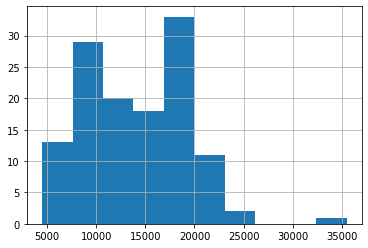

In [56]:
#Смесь распределений: выделяется два класса дорогих и дешевых товаров
data_shuffled['price'].hist()

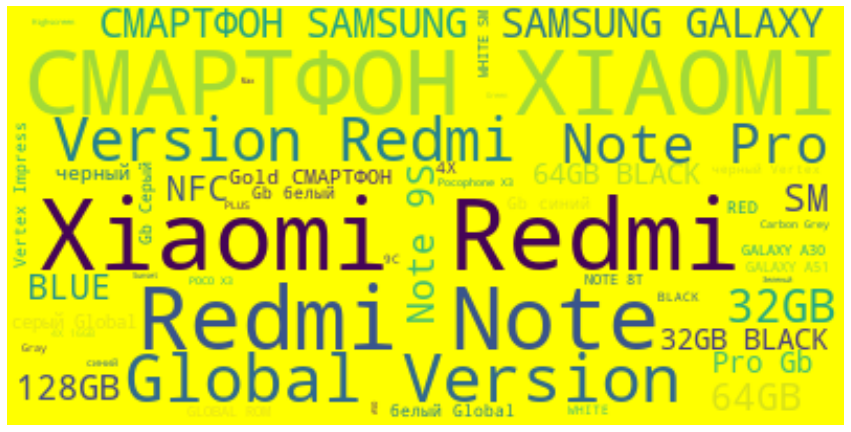

In [57]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in data.name)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=200, background_color="yellow").generate(text)
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [67]:
# подгружаем метрики
#метрики качества (можно взять несколько, R2, MAE, RMSE)
#Средняя абсолютная ошибка (MAE) представляет собой разницу между исходными и прогнозируемыми значениями, извлеченными посредством усредненной абсолютной разницы по набору данных.
#Среднеквадратическая ошибка (RMSE) это частота ошибок, вычисляемая квадратным корнем из MSE.
#Коэффициент детерминации (R2) - описявает качество модели. Чем выше значение, тем лучше модель (от 0 до 1, 1 идеальный)
#Средняя абсолютнаяпроцентная ошибка (MAPE) - процент кол-ва ошибок
#Среднеквадратическая ошибка (MSE) - представляет собой разницу между исходным и прогнозируемым значениями, извлеченными путем возведения в квадрат средней разницы по набору данных.
from sklearn import metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [68]:
#наивный бейзлайн по среднему
y_mean = np.median(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
measured_metrics["y_pred_naive"] = dataframe_metrics(y_test, y_pred_naive)
measured_metrics

,error_type,y_pred_naive
0,MAE,5182.653846
1,RMSE,6550.065182
2,R2,-0.000110
3,MAPE,45.830041


In [69]:
#2. Постройте модели простой линейной регрессии
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)

# Обучили модель на тренировочной выборке 
lin_reg.fit(X_train,y_train)
# Сделали прогнозы на тестовой выборке 
lin_reg_predict = lin_reg.predict(X_test)
measured_metrics["lin_reg"] = dataframe_metrics(y_test, lin_reg_predict)
measured_metrics

,error_type,y_pred_naive,lin_reg
0,MAE,5182.653846,2013.270447
1,RMSE,6550.065182,5584.019379
2,R2,-0.000110,0.273140
3,MAPE,45.830041,11.881842


In [70]:
###RidgeCV
from sklearn.linear_model import RidgeCV
# Объявили модель
ridge_cv = RidgeCV(cv=5)

# Обучили модель на тренировочной выборке 
ridge_cv.fit(X_train,y_train)
print('Лучшее значение параметра:', ridge_cv.alpha_)
# Сделали прогнозы на тестовой выборке 
pred_ridge_x = ridge_cv.predict(X_test)

measured_metrics["ridge_cv"] = dataframe_metrics(y_test, pred_ridge_x)
measured_metrics

Лучшее значение параметра: 10.0


,error_type,y_pred_naive,lin_reg,ridge_cv
0,MAE,5182.653846,2013.270447,1604.165532
1,RMSE,6550.065182,5584.019379,4797.671772
2,R2,-0.000110,0.273140,0.463441
3,MAPE,45.830041,11.881842,9.935065


In [71]:
from sklearn.linear_model import LassoCV

# Объявили модель
lasso_cv = LassoCV(cv=5)

# Обучили модель на тренировочной выборке 
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)
# Сделали прогнозы на тестовой выборке 
y_pred_lasso = lasso_cv.predict(X_test)

measured_metrics["lasso_cv"] = dataframe_metrics(y_test, y_pred_lasso)
measured_metrics

/home/nata/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197844.8271333892, tolerance: 197157.9549135803
  positive)
/home/nata/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613853.6500189193, tolerance: 201888.7286839506
  positive)
/home/nata/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283891.65315160714, tolerance: 201888.7286839506
  positive)


Лучшее значение параметра: 36.51704244331097


/home/nata/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 715003.0016235895, tolerance: 239706.69809900987
  positive)


,error_type,y_pred_naive,lin_reg,ridge_cv,lasso_cv
0,MAE,5182.653846,2013.270447,1604.165532,2082.914888
1,RMSE,6550.065182,5584.019379,4797.671772,5258.186948
2,R2,-0.000110,0.273140,0.463441,0.355491
3,MAPE,45.830041,11.881842,9.935065,13.748181
